In [1]:
from torchvision import datasets
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Download the training dataset and load
data_folder = '~/Documents/Projects/PyTorch/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [2]:
# Set the variables
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
# Download the validation dataset and load
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
# Import the needed packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Build a class that fetches the dataset.
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28) # (batch size, channels, height, width)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

# Define the model, optimizer and loss function.
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

# Function to train the dataset on a batch of images.
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

# Function to calculate the accuracy of a given dataset.
@torch.no_grad() # For inference
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [6]:
# Function that generates a training DataLoader from the dataset.
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [7]:
# Calculate the loss of the validation data.
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [8]:
# Initialize the model, loss function and optimizer.
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [9]:
# Model Summary
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [10]:
# Initialize the lists containing the training and validation accuracy as well as loss value over increasing epochs.
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


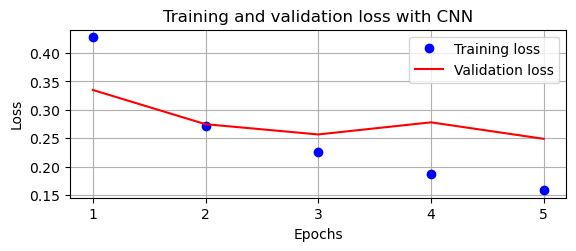

C:\Users\jilla\AppData\Local\Temp\ipykernel_15496\594049228.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


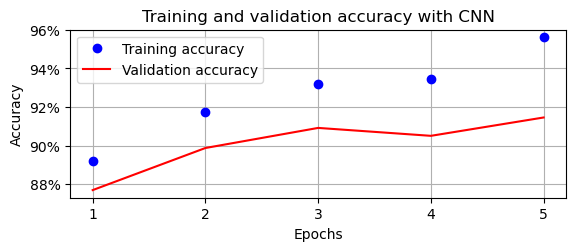

In [12]:
# Plot the accuracy and loss values in the training and validation datasets over increasing epochs.
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Translation

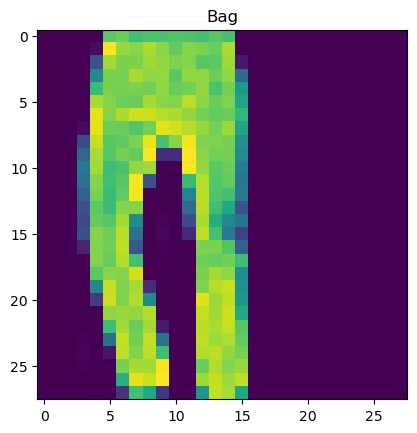

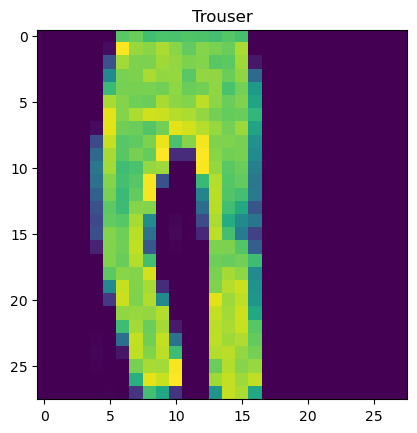

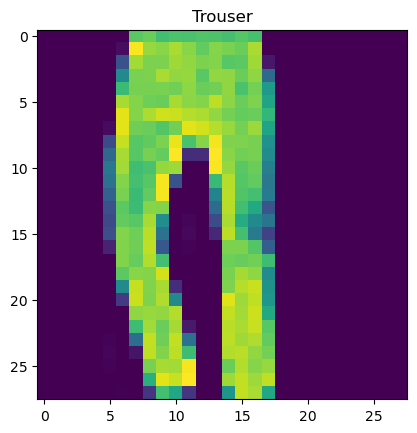

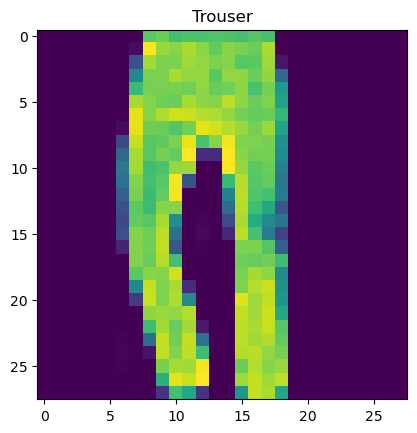

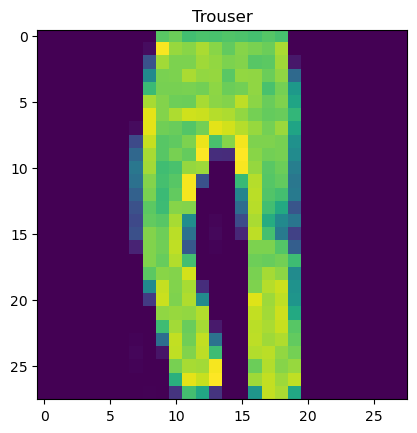

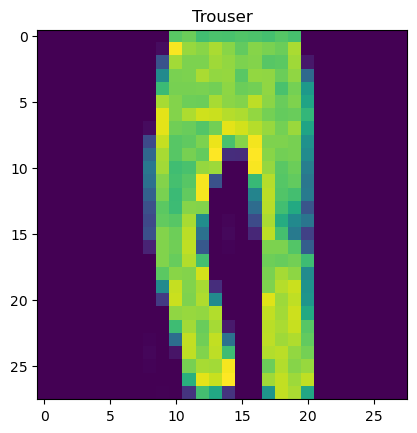

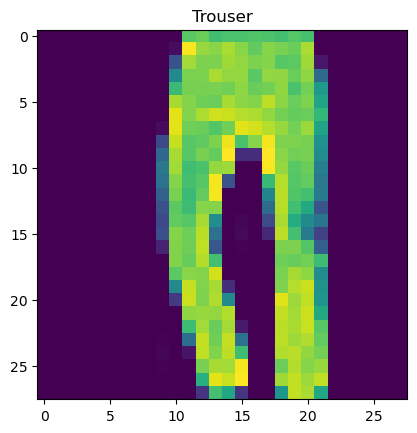

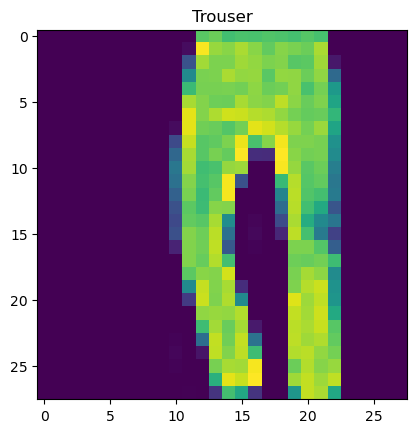

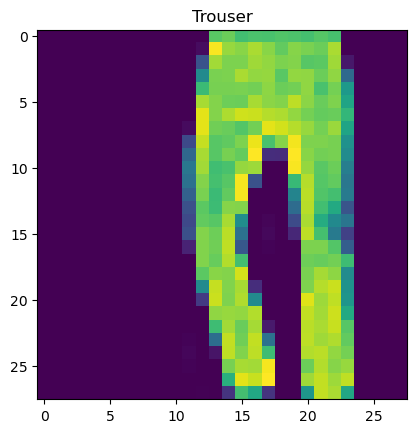

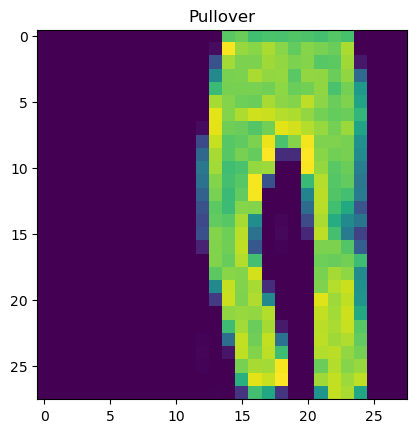

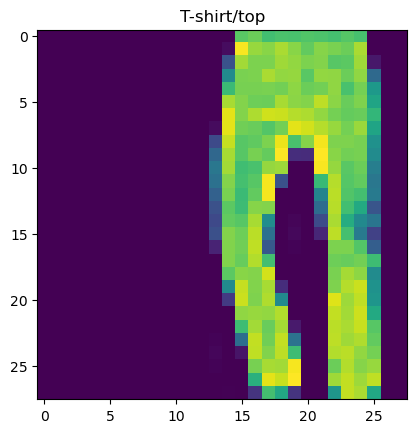

In [13]:
# Translate the image between -5 pixels to +5 pixels and predict its class.
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()

In [14]:
# Shape of the predictions
np.array(preds).shape

(11, 1, 10)

<Axes: title={'center': 'Probability of each class for various translations'}>

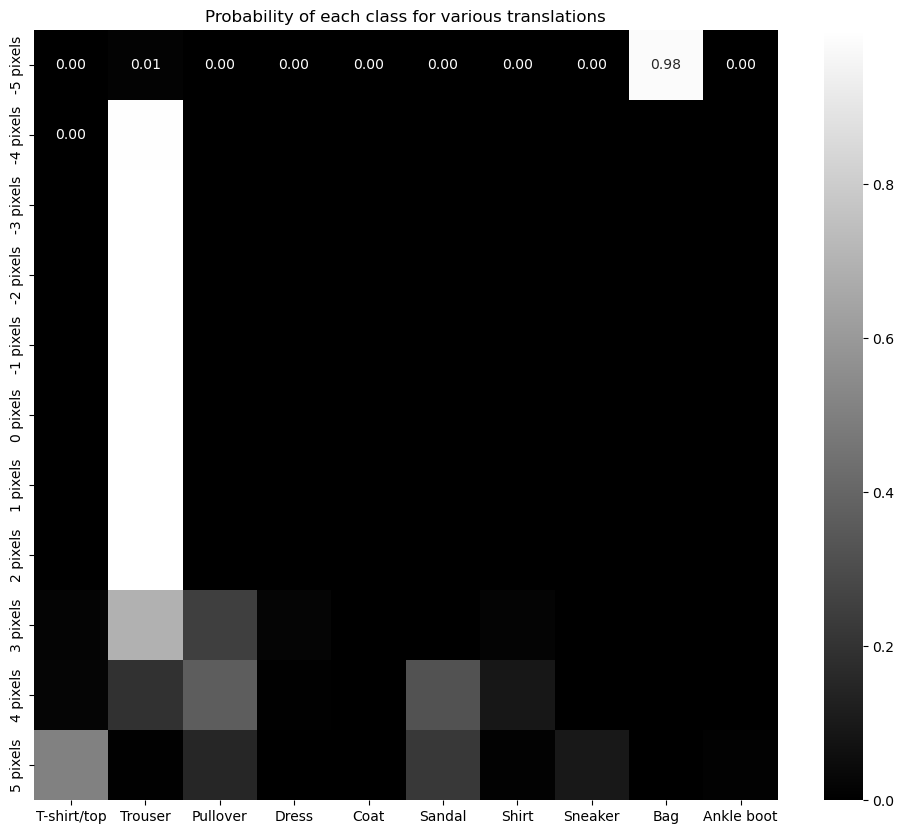

In [15]:
# Plot the probability of the classes across various translations.
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range (-5,6)], cmap='gray') 

Even after the image is translated, the model still predicted the classification correctly.

## Affine Transformations

In [19]:
# Import the packages
import imgaug
import imgaug.augmenters as iaa

def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

Text(0.5, 1.0, 'Original image')

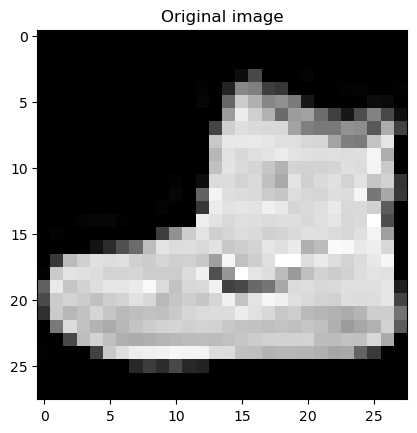

In [20]:
# Plot the first image
plt.imshow(tr_images[0], cmap='gray')
plt.title('Original image')

Text(0.5, 1.0, 'Scaled image')

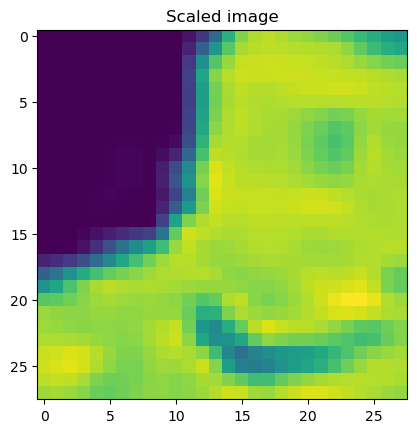

In [21]:
# Define an object that performs scaling
aug = iaa.Affine(scale=2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Scaled image')

The original output shape of the image has not changed resulting in a cropped image.

Text(0.5, 1.0, 'Translated image by 10 pixels (right and bottom)')

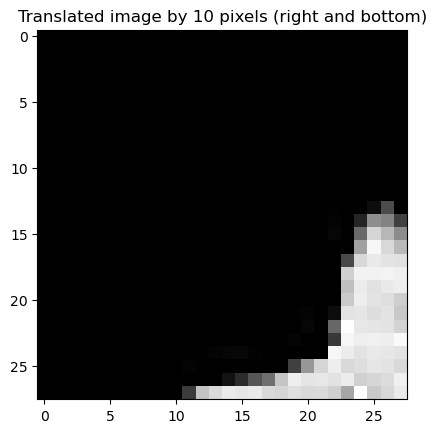

In [22]:
# Translate the image by 10 pixels.
aug = iaa.Affine(translate_px=10)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translated image by 10 pixels (right and bottom)')

Text(0.5, 1.0, 'Translation of 10 pixels \nacross columns and 2 pixels over rows')

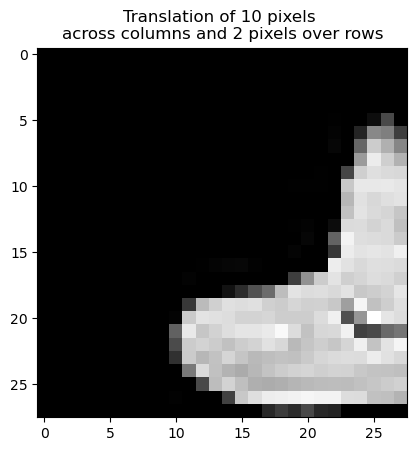

In [23]:
# Translate the image by 10 pixels on the x axis and 2 pixels on the y axis.
aug = iaa.Affine(translate_px={'x':10,'y':2})
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels \nacross columns and 2 pixels over rows')

Text(0.5, 1.0, 'Rotation of image by 30 degrees')

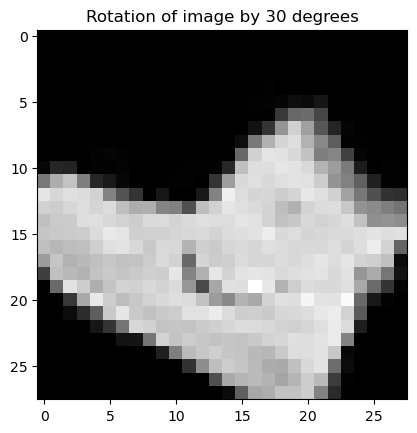

In [24]:
# Rotate the image by 30 degrees.
aug = iaa.Affine(rotate=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees')

Text(0.5, 1.0, 'Rotation of image by -30 degrees')

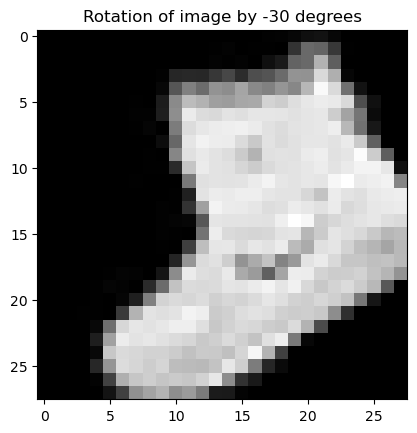

In [25]:
# Rotate the image by -30 degrees.
aug = iaa.Affine(rotate=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by -30 degrees')

Text(0.5, 1.0, 'Shear of image by 30 degrees')

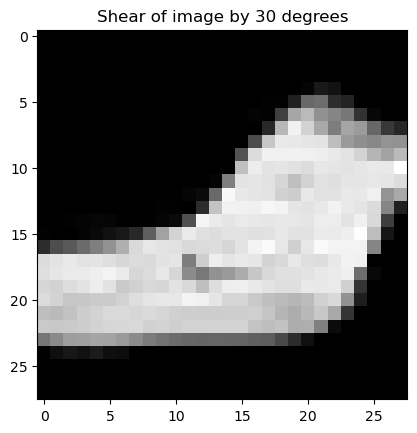

In [26]:
# Shear the image by 30 degrees.
aug = iaa.Affine(shear=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image by 30 degrees')

Text(0.5, 1.0, 'Shear of image by -30 degrees')

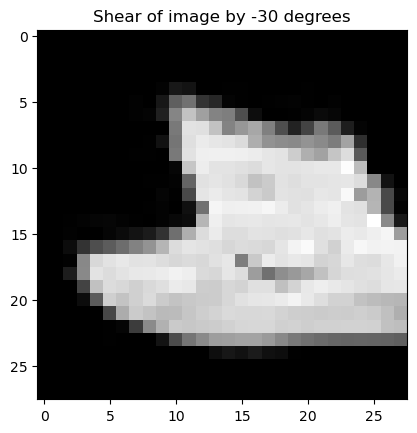

In [27]:
# Shear the image by -30 degrees.
aug = iaa.Affine(shear=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image by -30 degrees')

Text(0.5, 1.0, 'Shear of image \nby 30 degrees')

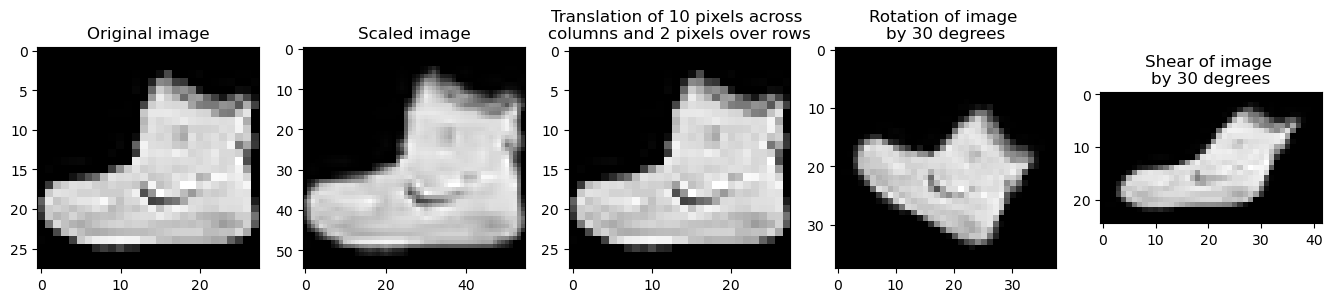

In [28]:
# Setting the fit_output parameter to True for comparison.
plt.figure(figsize=(20,20))
plt.subplot(161)
plt.imshow(tr_images[0], cmap='gray')
plt.title('Original image')
plt.subplot(162)
aug = iaa.Affine(scale=2, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Scaled image')
plt.subplot(163)
aug = iaa.Affine(translate_px={'x':10,'y':2}, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels across \ncolumns and 2 pixels over rows')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image \nby 30 degrees')
plt.subplot(165)
aug = iaa.Affine(shear=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image \nby 30 degrees')

With the fit_output set to True, the image was not cropped and instead the size of the image increased to accomodate for the augmented image. The cval parameter fills the missing pixels with a default value of 0 or black. Changing this value to 255 results in white pixels instead.

Text(0.5, 1.0, 'Shear of image \nby 30 degrees')

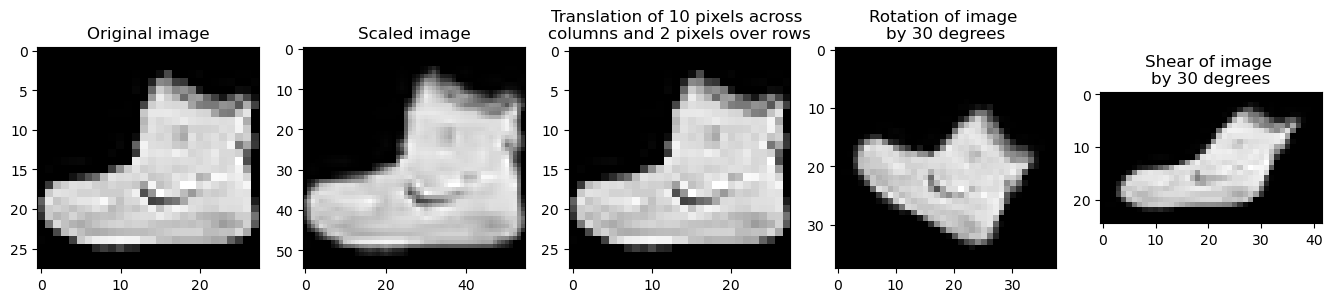

In [29]:
# Changing the cval parameter to 255.
plt.figure(figsize=(20,20))
plt.subplot(161)
plt.imshow(tr_images[0], cmap='gray')
plt.title('Original image')
plt.subplot(162)
aug = iaa.Affine(scale=2, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Scaled image')
plt.subplot(163)
aug = iaa.Affine(translate_px={'x':10,'y':2}, fit_output=True, cval = 255)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels across \ncolumns and 2 pixels over rows')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image \nby 30 degrees')
plt.subplot(165)
aug = iaa.Affine(shear=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image \nby 30 degrees')

Additional modes available in the mode parameter to fill the values for the new pixels:
- constant: Pads with a constant value
- edge: Pads with the edge values of the array
- symmetric: Pads with the reflection of the vector mirrored along the edge of the array
- reflect: Pads with the reflection of the vector mirrored on the first and last values of the vector along each axis
- wrap: Pads with the wrap of the vector along the axis

Text(0.5, 1.0, 'Rotation of image by \n30 degrees with wrap mode')

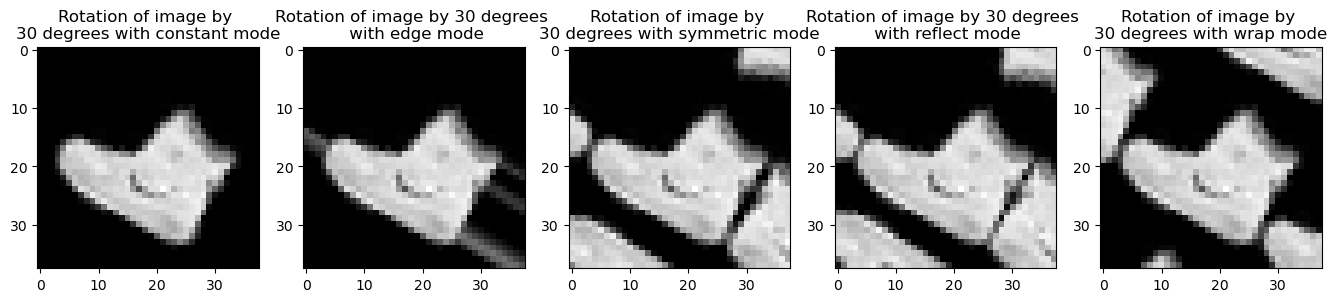

In [30]:
# Comparing the different modes
plt.figure(figsize=(20,20))
plt.subplot(161)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with constant mode')
plt.subplot(162)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='edge')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with edge mode')
plt.subplot(163)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='symmetric')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with symmetric mode')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='reflect')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with reflect mode')
plt.subplot(165)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='wrap')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with wrap mode')

Constant mode produces the best results

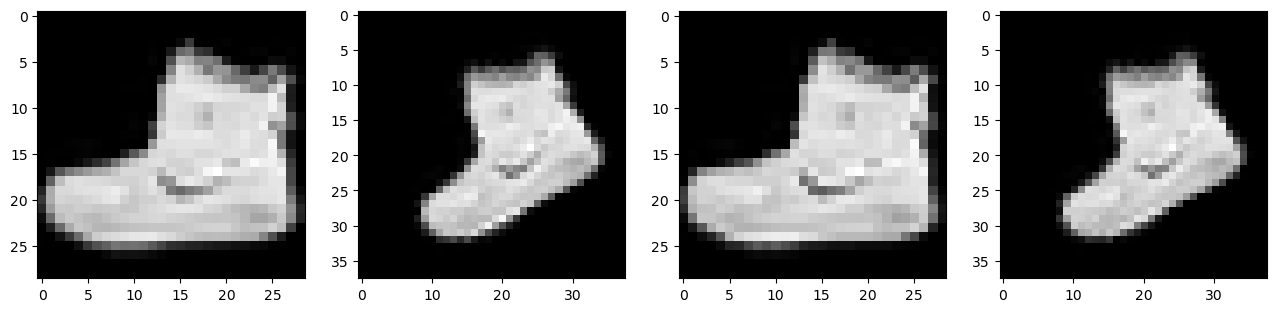

In [31]:
# Provide a range for the rotation instead of a fixed amount.
plt.figure(figsize=(20,20))
plt.subplot(151)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(152)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(153)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(154)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')

## Changing the Brightness

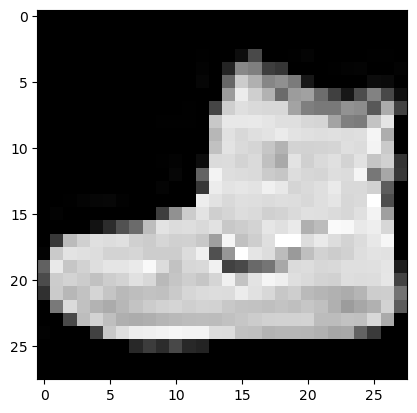

In [32]:
# The multiply method multiplies each pixel value by the value specified
aug = iaa.Multiply(1)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')

Text(0.5, 1.0, 'Pixels multiplied by 0.5')

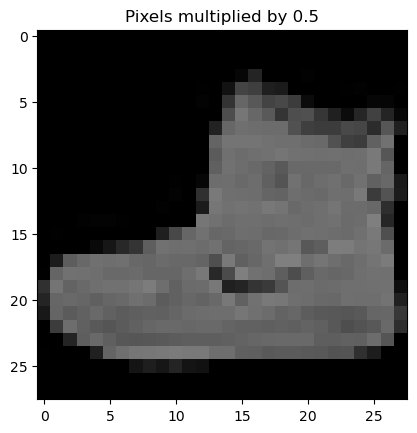

In [33]:
aug = iaa.Multiply(0.5)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Pixels multiplied by 0.5')

Text(0.5, 1.0, 'Pixel contrast by 0.5')

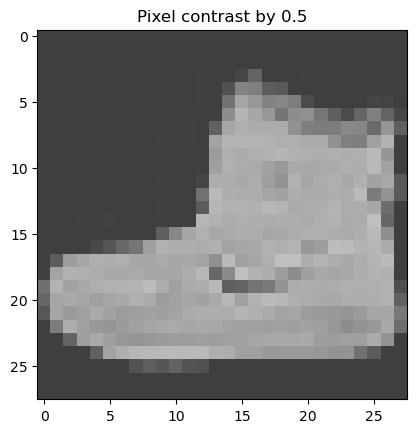

In [35]:
# The Linearcontrast mode adjusts each pixel using a formula. When the variable is less than 1, the high pixel values are reduced and the low pixel values are increased.
aug = iaa.LinearContrast(0.5)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Pixel contrast by 0.5')

## Adding Noise

Text(0.5, 1.0, 'Random 20% pixel dropout')

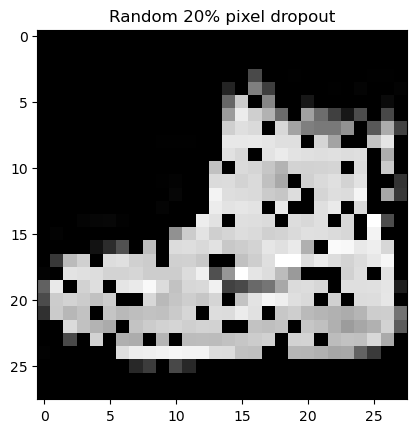

In [36]:
# Using the Dropout method to add noise to the image to simulate grainy image conditions
aug = iaa.Dropout(p=0.2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Random 20% pixel dropout')

Text(0.5, 1.0, 'Random 20% salt and pepper noise')

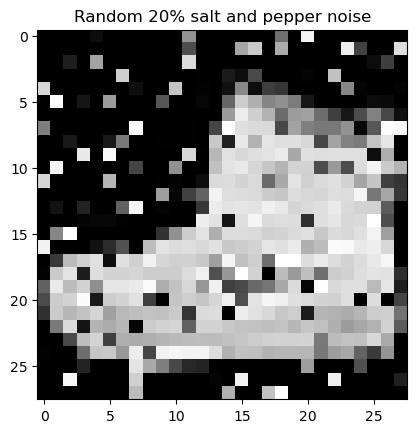

In [37]:
# Using the SaltAndPepper method to add noise to the image
aug = iaa.SaltAndPepper(0.2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Random 20% salt and pepper noise')

Text(0.5, 1.0, 'Image augmented using a \nrandom orderof the two augmentations')

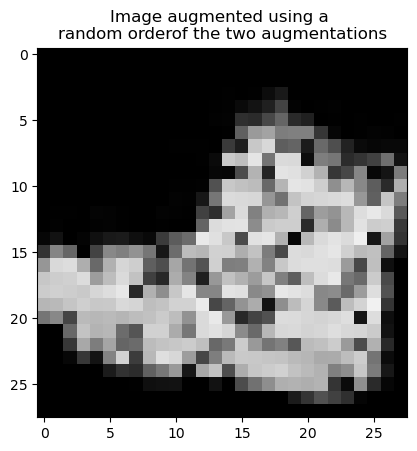

In [39]:
# Using the Sequential method, a series of augmentations on the image.
# This sequence will randomly use Dropout and rotate to modify the image.
seq = iaa.Sequential([
      iaa.Dropout(p=0.2,),
    iaa.Affine(rotate=(-30,30))], random_order= True)

plt.imshow(seq.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Image augmented using a \nrandom orderof the two augmentations')

Text(0.5, 1.0, 'Gaussian blurring of image\n with a sigma of 1')

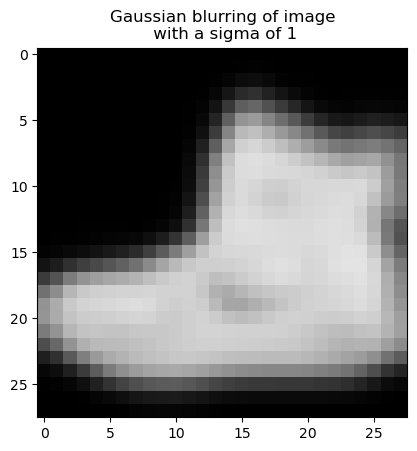

In [40]:
# Using the GaussianBlur method to blur the image
aug = iaa.GaussianBlur(sigma=1)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray',vmin = 0, vmax = 255)
plt.title('Gaussian blurring of image\n with a sigma of 1')